In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
import itertools
import logging
import unittest


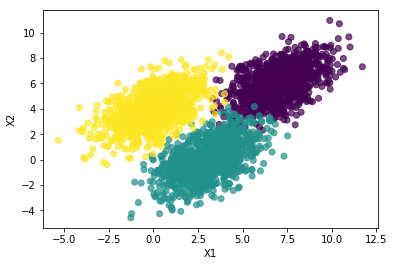

In [4]:
np.random.seed(10)
A = np.random.multivariate_normal([7, 6], [[2, 1],[1, 2]], 1000)
B = np.random.multivariate_normal([3, 0], [[2, 1],[1, 2]], 1000)
C = np.random.multivariate_normal([0, 4], [[2, 1],[1, 2]], 1000)
X = np.concatenate((A, B, C))
y = np.concatenate((np.array(["A" for i in range(A.shape[0])]), 
                    np.array(["B" for i in range(B.shape[0])]), 
                    np.array(["C" for i in range(C.shape[0])])))
cm = y.copy()
cm[cm == "A"] = 1
cm[cm == "B"] =2
cm[cm =="C"] =3
plt.figure()
plt.scatter(np.array([i[0] for i in X]), np.array([i[1] for i in X]), c = cm, alpha = 0.7)
#plt.scatter(*np.hsplit(X, 2), c = y)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)
mpl = MLPClassifier(activation = "logistic", solver = "sgd", max_iter=500,alpha=0.0001, shuffle = True)
mpl = mpl.fit(X_train,y_train)
mpl.score(X_test, y_test)


0.9833333333333333

AttributeError: 'int' object has no attribute '_getAssertEqualityFunc'

In [140]:
class Neural_network():
    def __init__(self, X = np.array, y = np.array, hidden_layer_size  = tuple, alpha = float, num_iter = int, lamb = float):
        self.X = X
        # each element in y needs to be converted into the representative vector to allow computation
        self.y_class = y
        self.unique_class = np.unique(y).tolist()
        #dataset is a numpy array with both the X and y (class representation) axis.
        self.dataset = np.concatenate((self.X, self.y_class.reshape(-1,1)), axis = 1)
        # convert the label into vector representation
        self.y = self.label_convert(y)            
        self.alpha = alpha
        self.num_iter = num_iter
        self.num_layer = len(hidden_layer_size) + 2
        # initialise the weight matrix here
        # the weight matrix of each layer is stored as elements inside a list
        # there should be (len(whole_network_size) - 1) number of weight matx
        self.weights = []

        self.number_of_output = np.unique(y).size
        self.whole_network_size = (X.shape[1],) + hidden_layer_size + (self.number_of_output,)
        for i in range(len(self.whole_network_size) - 1):
            ### initial weight shouldn't be zero
            d = self.whole_network_size[i] + 1 # +1 to account for bias unit
            limit = np.sqrt(1/d)
            # the weight is a N x M matrix, where N is number of unit in the next layer, and M is the number of unit of \ 
            # current layer + 1 bias unit
            weight = np.random.uniform(-limit, limit, (self.whole_network_size[i+1], self.whole_network_size[i] + 1))
 #           weight = np.zeros()
            self.weights.append(weight)
        self.lamb = lamb
        self.M = self.X.shape[0]
        
    def sigmoid(self, z = np.array):
        h = 1/(1+np.exp(-z))
        return h
    def softmax(self, z = np.array):
        h = np.exp(z)/(np.sum(np.exp(z)))
        return h
    def forward_propagation(self, x = np.array):
        # this is perform on one training example each time, and return the output as vector
        # for now only use sigmoid function for activation hiddent and input layer
        # forward propagation compute the sigmoid output of the dot product of Wi and ai up to the second last layer.
        # the output of that would be the next layer input 
        # current_input is a N x M matrix, where N is the number of features and M is the number of examples
        # the input (a) of each layer is stored in a list as vectors and has the structure of input layer + hidden layer

        inputs = []
 #       print (x)
        # start off with the features (X) as the first layer input (with bias unit). Input can always be expressed as a vector       
        current_input = np.insert(x, 0, 1.0).astype(np.float64).reshape(-1,1)
        if current_input.shape != (self.X.shape[1]+1,1):
            logging.warning("initial current_input shape is " + str(current_input.shape))
            
  #      current_input = np.concatenate(np.ones(x.shape), x).T
        inputs.append(current_input)
        for i in range(len(self.whole_network_size) -2):
            z = np.dot(self.weights[i], current_input)
            if z.shape != (self.whole_network_size[i+1], 1):
                logging.warning("z shape is " + str(z.shape))
            h = self.sigmoid(z)
            current_input = np.insert(h, 0, 1.0).astype(np.float64).reshape(-1,1)
            if current_input.shape != (self.whole_network_size[i+1] + 1,1):
                logging.warning("current_input shape is " + str(current_input.shape))
            inputs.append(current_input)
        #use softmax for final layer to compute the output, current input is now the input of the final hidden layer
        z = np.dot(self.weights[-1], current_input)
        if z.shape != (self.whole_network_size[-1], 1):
            logging.warning("final z shape is " + str(z.shape))
        output = self.softmax(z)  
        return (inputs, output)
    def backward_propagation(self, inputs = list, output = np.array, y_label = np.array):
        # deltas is a list of vectors with shape identical to the corresponding neuron node of each layers 
        # gradients is a list of matrices of the gradient of cost functions. such list and matrices should have the \
        # same shape as the list weights
        # back prop is performed on 1 training example each time (stochastic)
        global gradients
        global deltas
        deltas = []
        gradients = []

        #compute the delta value of the last layer (output layer) first then propagate backward with loop
        delta = (output - y_label).reshape(-1,1)
#         print (output)
#         print (y_label)
        if delta.shape != output.shape:
            logging.warning("initial delta shape is " + str(delta.shape))            
        deltas.append(delta)
        
        
#         print (deltas)
        # working backward from the last hidden layer, the gradient is computed and stored.
        # the delta value of such layer is then computed and stored
        # for the last layer (input), there's no regularisation term
        for i in range(len(self.whole_network_size)-2, -1, -1):
            print (i)
            if i == 0:
                lamb = 0
            else:
                lamb = self.lamb
                
            # if gradient return a single number, it's wrong. Should be the same shape as weight.
            if i == len(self.whole_network_size)-2:
                if delta.shape != (self.weights[i].shape[0], 1):
                    logging.warning(str(i) +" delta shape is" + str(delta.shape) + " when it is supposed to be " + str((self.weights[i].shape[0], 1)))
            else:
                if delta.shape != (self.weights[i].shape[0], 1):
                    logging.warning(str(i) +" delta shape is" + str(delta.shape) + " when it is supposed to be " + str((self.weights[i].shape[0], 1)))
                
            if inputs[i].T.shape != (1, self.weights[i].shape[1]):
                logging.warning("input shape is" + str(inputs[i].T.shape))
                
            gradient = np.dot(delta, inputs[i].T)  + (self.lamb/ self.M) * self.weights[i]
#             if gradient.shape != (self.weights[i].shape:
#                 logging.warning("gradient shape is" + str(gradient.shape)  when it should be )
                
            gradients.insert(0, gradient)
            
            delta = np.dot(self.weights[i].T, delta) * inputs[i] * (1 - inputs[i])
            delta = np.delete(delta, 0, axis = 0)
            deltas.insert(0, delta)
            print (deltas)
        # check if shape of gradients is the same as weights
        for i in gradients:
            if gradients[i].shape != self.weights[i].shape:
                logging.warning("gradient shape is" + str(gradient.shape))
        return gradients

    def gradient_descent(self, gradients = list):
        #gradients should have the exact same structure as weights (list of matrices)
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i] - self.alpha * gradients[i] # regularisation term already taken into account during back prop
    def label_convert(self, y):
        converted_output = []
        for label in y:
            output_vector = np.zeros(np.unique(y).size)
            index_num = self.unique_class.index(label)
            output_vector[index_num] = 1
            converted_output.append(output_vector)
        return np.array(converted_output)    
        
        
    def fit(self):
        global inputs
        step = 0
        np.random.shuffle(self.dataset)
        X_shuffled, y_shuffled = np.hsplit(self.dataset, [self.dataset.shape[1]- 1,])
        y_shuffled = self.label_convert(y_shuffled)  
        for index in itertools.cycle(range(X_shuffled.shape[0])):
            x = X_shuffled[index]
            inputs, output = self.forward_propagation(x)
            gradients = self.backward_propagation (inputs = inputs, output = output, y_label = y_shuffled[index].reshape(-1,1))
            gradient_descent(gradients = gradients)    
            step += 1
            if step > self.num_iter:
                break
        return (self.weights)
    def predict(X_test = np.array):
        class_output = []
        #convert the vector into the corresponding class with the highest score,
        inputs, outputs = self.forward_propagation(X_test)
        outputs = np.round(outputs).tolist()
        for output in outputs:
            index_num = output.index(1)
            clas = self.unique_class[index_num]
            class_output.append(clas)

        return np.array(class_output)

    def score(X_test = np.array, y_test = np.array):
        #compare the output to the actual label and work out the accuracy ratio.
        predicted_outputs = self.predict(X_test)
        accu = (predicted_outputs == y_test).sum()/len(predicted_output)
        return accu          

In [141]:
C = Neural_network(X_train, y_train, hidden_layer_size = (4,4), alpha = 0.0001, num_iter = 10000, lamb = 0)
C.fit()

2
[array([[ 0.01973313],
       [-0.02276763],
       [ 0.04137807],
       [ 0.03825045]]), array([[ 0.49653708],
       [-0.78764499],
       [ 0.29110791]])]
1
[array([[-0.0007966 ],
       [ 0.00093611],
       [-0.00236293],
       [ 0.00311189]]), array([[ 0.01973313],
       [-0.02276763],
       [ 0.04137807],
       [ 0.03825045]]), array([[ 0.49653708],
       [-0.78764499],
       [ 0.29110791]])]
0
[array([[ 0.01586809],
       [-0.00532285]]), array([[-0.0007966 ],
       [ 0.00093611],
       [-0.00236293],
       [ 0.00311189]]), array([[ 0.01973313],
       [-0.02276763],
       [ 0.04137807],
       [ 0.03825045]]), array([[ 0.49653708],
       [-0.78764499],
       [ 0.29110791]])]


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
gradients

In [132]:
for i in C.weights:
    print (i.shape)
for i in inputs:
    print (i.shape)

(4, 3)
(4, 5)
(3, 5)
(3, 1)
(5, 1)
(5, 1)


In [103]:
np.concatenate((X_train, y_train))

ValueError: all the input arrays must have same number of dimensions

In [58]:
str((2400, 3))

'(2400, 3)'

In [ ]:
x = C.X[0]

In [ ]:
x

In [ ]:
current_input = np.concatenate(np.array([0,]), x).T

In [ ]:
x.shape

In [ ]:
np.ones(x.shape)

In [ ]:
x

In [ ]:
np.concatenate(x, x)

In [ ]:
x = np.insert(x, 0, 1)

In [ ]:
np.dot(C.weights[0], x)

In [ ]:
x.shape

In [ ]:
C.weights[0].shape

In [ ]:
for i in C.weights:
    print (i.shape)

In [ ]:
limit = np.sqrt(1/10)

In [ ]:
np.random.RandomState.uniform(-1, 1, 1000)

In [ ]:
np.random.uniform(-1,0,1000)

In [34]:
arr = np.ones((3,3)).astype(np.float64)

In [40]:
type(arr[0][0])

numpy.float64